## HW 3
### Due Apr. 15th by end of day.
### Name your notebook by firstname.lastname.hw3.ipynb and email it to zhang@csc.lsu.edu

In this HW, we take a look at text processing using RNN based on LSTM. Given a review (hundred to thousand words long) about a movie, we want to classify the review as positive or negative (sentiment analysis). A model is given in this notebook that runs RNN, consisting of a single layer of LSTM cells, on the word sequence of the rewiews. Each review is transformed into a vector, which is the average of the LSTM vectors over the sequence. A softmax layer is then used to classify the reviews based on the LSTM vector representation. 

Your goal is to train the model and gain some idea on the computation challenge when training "deep" model for a large number of iterations.  

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import time

import numpy
import theano
import theano.tensor as T

from lstm import load_data, prepare_data, batches_idx, lstm_layer, rmsprop

### Model meta parameters

 - n_hidden: # of neurons in the LSTM layer
 - n_words: # of words in the dictionary. We use most frequent words. All other words are treated as unknown.
 - n_sample: max size (# of reviews) of the train dataset and the test dataset. (We may not be able to reach the max because if we want only reviews up to 50 words, there may be less than max such reviews in the whole data collection.)  
 - maxlen: max length in number of words for a review to be considered. Review longer than this will be ignored. This is also the # of recurrent steps.


In [4]:
n_hidden = 10
n_words = 500
n_sample = 1000
maxlen = 50

### Load data. 
First parameter to load_data function should be the path to the data files (*.pkl.gz) on your computer.

In [5]:
train, test, translate = load_data('./', n_words, n_sample, maxlen)

In [6]:
print 'num of pos in train:', numpy.sum(train[1]), 'out of', len(train[1])
print 'num of pos in test:', numpy.sum(test[1]), 'out of', len(test[1])

num of pos in train: 169 out of 269
num of pos in test: 163 out of 293


In [7]:
def build_model(n_hidden, n_words):

    x = T.matrix('x', dtype='int64')
    mask = T.matrix('mask', dtype='float64')
    y = T.vector('y', dtype='int64')

    # embedding params
    randn = numpy.random.rand(n_words, n_hidden)
    Wemb = theano.shared(0.01 * randn)
    
    #lstm layer
    lstm = lstm_layer(n_hidden)
    
    # classifier params
    CU = theano.shared(0.01 * numpy.random.randn(n_hidden, 2))
    Cb = theano.shared(numpy.zeros((2,)))
    params = lstm.params + [Wemb, CU, Cb]
    
    
    n_timesteps = x.shape[0]
    n_samples = x.shape[1]

    emb = Wemb[x.flatten()].reshape([n_timesteps, n_samples, n_hidden])
    proj = lstm.calc_lstm(emb, mask)
    proj = (proj * mask[:, :, None]).sum(axis=0)
    proj = proj / mask.sum(axis=0)[:, None]

    pred = T.nnet.softmax(T.dot(proj, CU) + Cb)

    f_pred = theano.function([x, mask], pred.argmax(axis=1), name='f_pred')

    off = 1e-8
    cost = -T.log(pred[T.arange(n_samples), y] + off).mean()

    return x, mask, y, params, cost, f_pred

In [8]:
(x, mask, y, params, cost, f_pred) = build_model(n_hidden, n_words)
grads = T.grad(cost, params)    

lr = T.scalar(name='lr')
f_grad_shared, f_update = rmsprop(lr, params, grads, x, mask, y, cost)

lrate=0.1
updates = [(p, p - lrate * g) for p, g in zip(params, grads)]
f_sgd = theano.function([x, mask, y], cost, updates=updates)

In [9]:
nepoch = 5000
cc = numpy.zeros((nepoch,))
t0 = time.time()
for i in range(nepoch):
    cost = 0
    for train_index in batches_idx(len(train[0]), 100):
        y = [train[1][t] for t in train_index]
        x = [train[0][t]for t in train_index]
        x, mask, y = prepare_data(x, y)
        
        cost += f_grad_shared(x, mask, y)
        f_update(lrate)
        #cost += f_sgd(x, mask, y)
        
    print 'iteration:', i, 'cost=', cost
    cc[i] = cost
print 'run time:', (time.time()-t0)/60.0  #training time in min.

iteration: 0 cost= 2.07899000184
iteration: 1 cost= 2.07684290686
iteration: 2 cost= 2.07380142917
iteration: 3 cost= 2.07035122041
iteration: 4 cost= 2.06671204112
iteration: 5 cost= 2.06299156202
iteration: 6 cost= 2.05924121651
iteration: 7 cost= 2.0554829888
iteration: 8 cost= 2.05172375966
iteration: 9 cost= 2.04796344604
iteration: 10 cost= 2.04419979511
iteration: 11 cost= 2.04043129123
iteration: 12 cost= 2.03665895876
iteration: 13 cost= 2.03288748197
iteration: 14 cost= 2.02912585396
iteration: 15 cost= 2.02538763799
iteration: 16 cost= 2.02169084577
iteration: 17 cost= 2.01805739992
iteration: 18 cost= 2.01451215242
iteration: 19 cost= 2.01108147899
iteration: 20 cost= 2.0077915528
iteration: 21 cost= 2.00466649385
iteration: 22 cost= 2.00172665316
iteration: 23 cost= 1.99898728924
iteration: 24 cost= 1.99645781936
iteration: 25 cost= 1.99414170381
iteration: 26 cost= 1.99203689477
iteration: 27 cost= 1.99013669202
iteration: 28 cost= 1.98843081444
iteration: 29 cost= 1.9869

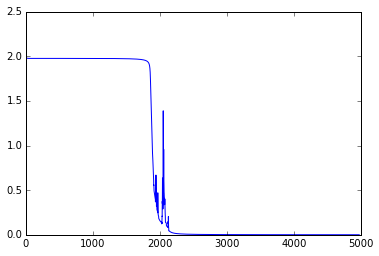

In [10]:
plot(cc[20:])

In [11]:
np.min(cc)

0.00068654013435211301

In [12]:
tx, tmask, ty = prepare_data(test[0], test[1])
py = f_pred(tx, tmask)
print 'error rate =', 1.0*numpy.sum(numpy.abs(ty - py))/len(test[0])

error rate = 0.382252559727


## Task 1
Investigate test error rate with respect to training iterations. 

  - Plot error rate for test data v.s. number of iterations.  
  
Train the model until "cost" gets close to 0 (smaller than 0.01). You don't need to get error rate every iteration. Rather, every 250 or 500 iterations, call f_pred to make prediction on the test data and calculated error rate (an example is given above for prediction and error rate calculation).

### Make plot on this notebook and submit the notebook with the plot. I'd like to see the plot besides your code.

## Task 2
Investigate training time with respect to the following parameters:
  - n_hidden (# of neurons in the LSTM layer)
  - maxlen (max length in number of words for a review), i.e., # of recurrent steps

Fix the number of training iterations (i.e., 200), vary (increase the values of) the parameters and measure the training time. (Don't make small changes of values, e.g., from 10 to 11. You should make significant change of the values, e.g., from 10 to 20 to 50 to 100 etc.) Try several values and make the following plots: 
  - training time v.s. n_hidden
  - training time v.s. maxlen
  
### Make plot on this notebook and submit the notebook with the plot. I'd like to see the plot besides your code.